## Preprocessing and inference

In [1]:
using RCall, Distributions, Gadfly, MultivariateStats, DataFrames
include("../multiallelegibbs.jl");
include("../eigenanlaysis.jl");
include("../singleallelesampler.jl");


Attaching package: ‘dplyr’

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

data.table 1.9.6  For help type ?data.table or https://github.com/Rdatatable/data.table/wiki
The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last



Load in and preprocess pedigree and genotype data using R and import it to Julia. 

Because in this analysis linkage disequilibrium (LD) (that is, dependence between SNPs due to proximity) will look much the same as population structure, I'm using only SNPs that are farther than $3*10^5$ base pairs away from each other (based on existing literature on rhesus LD and eyeballing it in our own sample). This comes out to 70 SNPs.

In [18]:
rcopy("type='eigenanalysis'");
rcopy("source('../pedR2jl.R')");

Warning in ped.theclaw(pedigree$sire) : NAs introduced by coercion
Warning in ped.theclaw(pedigree$dam) : NAs introduced by coercion


In [19]:
geno = convert(Array{Int64,2},rcopy("X"));
ped = rcopy("numped");
rcopy("rm(list=ls())");
rcopy("gc()");

Run the Gibbs sampler for longer than is probably necessary.

In [24]:
n,m = size(geno);
iter = 500;
thin = 2;
nsamp = length(thin:thin:iter);

In [25]:
@time pedfit = pedigree_genogibbs(geno,ped,iter,thin);

656.956171 seconds (5.36 G allocations: 155.202 GB, 2.12% gc time)


If necessary, load samples back up rather than rerunning the sampler.

In [6]:
savepath = "/home/seth/analysis/ppc4ped/eigenanalysis_";
pedfit = pedigree_loadsamp(savepath);
n,m,nsamp = size(pedfit[1]);

## Aside: Genotyping error rates

Playing around with the runs suggested that the genotyping error rate took some time to stabilize. The plot below suggests that it settles down about 100 samples into the run.

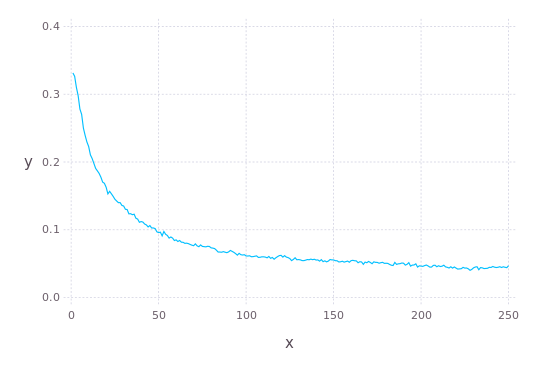

In [26]:
Gadfly.plot(x=1:nsamp,y=pedfit[3],Geom.line)

Interestingly, the posterior genotyping error rate seems entirely concentrated between 1% and 2%, which is small but not negligible. To be certain that this is not just an artifact of the prior I used ($Beta(1,20)$ to be precise), I made a quick comparison between the prior and the posterior genotype error rates.

In [27]:
Gadfly.plot(layer(x=0:.001:0.05,y=pdf(Beta(1,20),0:.001:0.05),Geom.line),
layer(x=pedfit[3][201:500],Geom.density,Theme(default_color=color("red"))),
Scale.y_continuous(minvalue=0,maxvalue=300))


LoadError: LoadError: BoundsError: attempt to access 250-element Array{Float64,1} at index [201:500]
while loading In[27], in expression starting on line 1

The posterior is astronomically narrower than the prior, so it seems like that 1.5% error rate is coming mostly from the data itself. It may be worth taking a quick look to see whether there are any particular SNPs or monkeys with high error probabilities.

# Population structure!

Now that we have the posterior of the minor allele frequencies (MAFs), I'll use those to generate posterior predictive genotypes (ppgeno below) by simulating a population with the same founding minor allele frequencies and the same pedigree.

Also, I use the posterior MAFs to simulate a structureless population where every animal is unrelated (nullgeno below)... though now that I think about it, perhaps it would make more sense to use the MAF estimates from a model that ignores the pedigree, rather the posterior MAF from the model that uses the pedigree. Well, I'm sure it makes very little difference in the end.

In [28]:
genotyped = (sum(geno.!=-1,2).>1)[:];
ng = countnz(genotyped);
tsim = size(pedfit[2],2);
burnin = 50;
nsim = tsim - burnin;

nullgeno = Array(Int8,(ng,m,nsim));
for t in 1:nsim
    for j in 1:m
        nullgeno[:,j,t] = rand(Binomial(2,pedfit[2][j,t+burnin]),ng);
    end
end

ppgeno = Array(Int8,(n,m,nsim));
for t in 1:nsim
    for j in 1:m
        ppgeno[:,j,t] = pedigree_genosim(ped,pedfit[2][j,t+burnin])[1];
    end
end
ppgeno = ppgeno[genotyped,:,:];

In [29]:
peig = pedigree_eigenanalysis(pedfit[1][genotyped,:,(burnin+1):tsim]);
ppeig = pedigree_eigenanalysis(ppgeno);
nulleig = pedigree_eigenanalysis(nullgeno);

In [52]:
df=DataFrame(eigenvalue=vcat(peig[2],ppeig[2],nulleig[2])[:],component=repeat(collect(1:m),inner=[3]),
qlow=vcat(peig[4][:,1],ppeig[4][:,1],nulleig[4][:,1][:]),
qhigh=vcat(peig[4][:,2],ppeig[4][:,2],nulleig[4][:,2][:]),
model=repeat(["Cayo","PPD","unrelated"],inner=[m]))


,eigenvalue,component,qlow,qhigh,model
1,3.646592417047478,1,3.534581730178155,3.748264460551118,Cayo
2,3.527884700559106,1,3.407098429414786,3.6123237657831906,Cayo
3,3.405918569103751,1,3.283406658631061,3.5121796233856357,Cayo
4,3.2939415626047084,2,3.170384104871357,3.399182486638754,Cayo
5,3.1333281812840115,2,2.9384933767748698,3.257934833152329,Cayo
6,2.9258747332690125,2,2.80158900549967,3.02261427139415,Cayo
7,2.805721302446811,3,2.697982963321658,2.9206201342051963,Cayo
8,2.6804793862372027,3,2.6044483354316057,2.7606714360855915,Cayo
9,2.589894326899605,3,2.518730456284401,2.651936991083048,Cayo
10,2.516683664309769,4,2.4573806740151727,2.5828966301007,Cayo


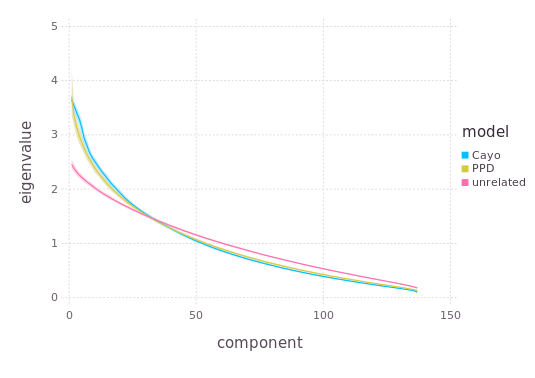

In [54]:
df=DataFrame(eigenvalue=vcat(peig[2],ppeig[2],nulleig[2])[:],component=repeat(collect(1:m),outer=[3]),
qlow=vcat(peig[4][:,1],ppeig[4][:,1],nulleig[4][:,1][:]),
qhigh=vcat(peig[4][:,2],ppeig[4][:,2],nulleig[4][:,2][:]),
model=repeat(["Cayo","PPD","unrelated"],inner=[m]));

p = Gadfly.plot(df,y="eigenvalue",x="component",ymin="qlow",ymax="qhigh",
color="model",Geom.line,Geom.ribbon)

This should be a familiar looking plot by now -- the y-axis is the eigenvalues, the x-axis is the ordered eigenvector number. Red curve is what a population with no structure would look like, blue is the observed genotyes (with missing genotype imputation provided by the model we just fit), and yellow is the posterior predictive distribution (ppd) for a population with matching MAFs and pedigree.

To get a slightly clearer look at the deviations between the true data and the ppd, below I plot the posterior of the difference between the true data and the other distributions.

In [55]:
ppdiff = ppeig[1] - peig[1];
nulldiff = nulleig[1] - peig[1];
ppdiffci = Array(Float64,(m,2));
nulldiffci = Array(Float64,(m,2));
for i in 1:m
    ppdiffci[i,:] = quantile(vec(ppdiff[i,:]),[0.005,0.995]);
    nulldiffci[i,:] = quantile(vec(nulldiff[i,:]),[0.005,0.995]);
end

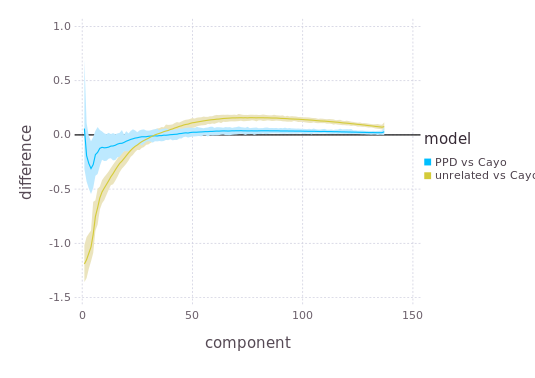

In [60]:
df2 = DataFrame(difference=vcat(mean(ppdiff,2),mean(nulldiff,2))[:],component=repeat(collect(1:m),outer=[2]),
qlow=vcat(ppdiffci[:,1],nulldiffci[:,1]),qhigh=vcat(ppdiffci[:,2],nulldiffci[:,2]),
model=repeat(["PPD vs Cayo","unrelated vs Cayo"],inner=[m]));

p2=Gadfly.plot(df2,x="component",y="difference",ymin="qlow",ymax="qhigh",color="model",
yintercept=[0],Geom.line,Geom.ribbon,Geom.hline(color="black"))

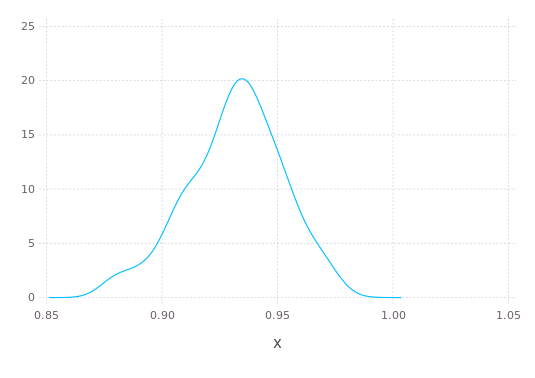

In [61]:
r2 = (sumabs2(nulldiff,1) - sumabs2(ppdiff,1))./sumabs2(nulldiff,1)
Gadfly.plot(x=r2,Geom.density)

In [62]:
print(mean(r2))
quantile(vec(r2),[0.025,0.975])

0.9314345914448439

2-element Array{Float64,1}:
 0.883629
 0.969864

Blue is the posterior of the difference between the true data and the ppd (from the model with the pedigree), yellow is the difference with the null (pedgree-free) model. Being at or near 0 indicates that the model is consistent with the observed population structure.  I'm not sure where that kink at the end is coming from, but other than that it looks like pedigree accounts *almost* perfectly for the observed population structure. And at the very least it looks cleaner than the post-hoc analyses done before. However, there are a few points where they don't perfectly line up... this could be due to LD, but I suspect it is because of the missing paternity information.

In theory I could try to build that stuff into the model, but that's probably not worth the effort.